# Deep Convolutional GANs

Brief introduction to Deep Convolutional Generative Adversarial Networks or DCGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training DCGANs with MNIST dataset, Keras and TensorFlow**

## 1. Research Paper

* [Unsupervised Representation Learning With Deep Convolutional](https://arxiv.org/pdf/1511.06434.pdf)

## 2. Background

Brief definition of some concepts, such as convolution, Convolutional Neural Network (CNN) and GANs.

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

![convolution](https://devblogs.nvidia.com/wp-content/uploads/2015/11/convolution.png)

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

### GANs

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **cost function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.

DCGAN are mainly composes of convolution layers without max pooling or fully connected layers. It uses convolutional stride and transposed convolution for the downsampling and the upsampling. 

### Network Design

<img src="../../img/network_design_dcgan.png" width="600"> 


### Cost Funcion


$$ \underset{G}{min} \: \underset{D}{max} \; V_{DCGAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

> * Replace all max pooling with convolutional stride.
    Use transposed convolution for upsampling.
    Eliminate fully connected layers.
    Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
    Use ReLU in the generator except for the output which uses tanh.
    Use LeakyReLU in the discriminator.*

## 4. Training DCGANs with MNIST dataset,  Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.

* **Data**
    * Rescale the MNIST images to be between -1 and 1.
    
* **Generator**
    * Use the **inverse of convolution**, called transposed convolution.
    * **ReLU activation** and **BatchNormalization**.
    * The input to the generator is the **normal distribution** $z$ or latent sample (100 values).
    * The last activation is **tanh**.
    
* **Discriminator**
    * **Convolutional neural network**  and **LeakyReLU activation**.
    * The last activation is **sigmoid**.
    
* **Loss**
    * binary_crossentropy

* **Optimizer**
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100

### 1. Load data

#### Load libraries

In [19]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model
from keras import backend as K

#### Getting the data

In [21]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

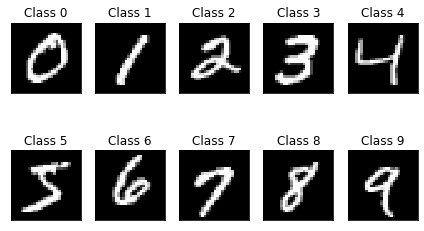

In [22]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [23]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

In [24]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 7x7x256
generator.add(Dense(7*7*128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((7, 7, 128)))

# Conv 1: 14x14x128
generator.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# Conv 2: 28x28x64
generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
generator.add(BatchNormalization(momentum=0.8))
generator.add(ReLU(0.2))

# # Conv 3: 28x28x32
# generator.add(Conv2DTranspose(32, kernel_size=3, strides=1, padding='same'))
# generator.add(BatchNormalization(momentum=0.8))
# generator.add(ReLU(0.2))

# Conv 4: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same', activation='tanh'))

#### Generator model visualization

In [25]:
# prints a summary representation of your model
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       73792     
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_2 (ReLU)              (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 32)      

#### Discriminator

In [26]:
# Discriminator network
discriminator = Sequential()

# Conv 1: 14x14x64
discriminator.add(Conv2D(32, kernel_size=3, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [27]:
# prints a summary representation of your model
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                      

### 3. Compile model

#### Compile discriminator

In [28]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### Combined network

We connect the generator and the discriminator to make a DCGAN.

In [29]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

#### GAN model vizualization

In [30]:
# prints a summary representation of your model
d_g.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         726401    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 95489     
                                                                 
Total params: 821,890
Trainable params: 726,209
Non-trainable params: 95,681
_________________________________________________________________


### 4. Fit model

epoch = 1/100, d_loss=0.164, g_loss=0.288                                                                                                                                                                                                                          


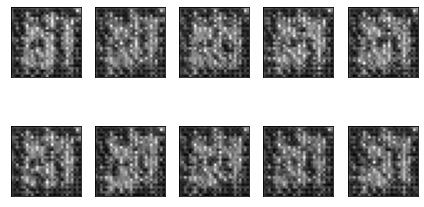

epoch = 2/100, d_loss=0.163, g_loss=0.249                                                                                                                      
epoch = 3/100, d_loss=0.163, g_loss=0.239                                                                                                                      
epoch = 4/100, d_loss=0.168, g_loss=0.213                                                                                                                      
epoch = 5/100, d_loss=0.165, g_loss=0.115                                                                                                                      
epoch = 6/100, d_loss=0.164, g_loss=0.155                                                                                                                                                                                                                          
epoch = 7/100, d_loss=0.164, g_loss=0.103                                                           

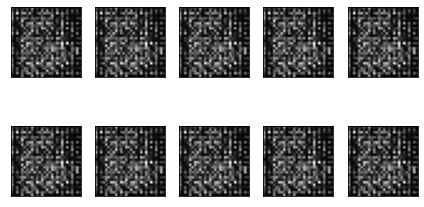

epoch = 12/100, d_loss=0.164, g_loss=0.164                                                                                                                      
epoch = 13/100, d_loss=0.165, g_loss=0.143                                                                                                                      
epoch = 14/100, d_loss=0.164, g_loss=0.127                                                                                                                      
epoch = 15/100, d_loss=0.164, g_loss=0.171                                                                                                                                                                                                                                                                                                                               
epoch = 16/100, d_loss=0.163, g_loss=0.125                                                                                                                 

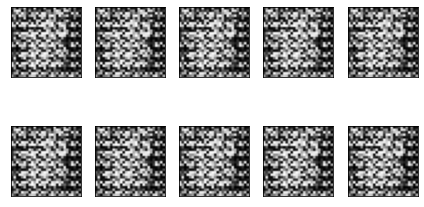

epoch = 22/100, d_loss=0.164, g_loss=0.213                                                                                                                                                                                                                          
epoch = 23/100, d_loss=0.163, g_loss=0.316                                                                                                                      
epoch = 24/100, d_loss=0.163, g_loss=0.341                                                                                                                      
epoch = 25/100, d_loss=0.163, g_loss=0.507                                                                                                                                                                                                                                                                                                                                
epoch = 26/100, d_loss=0.165, g_loss=0.648            

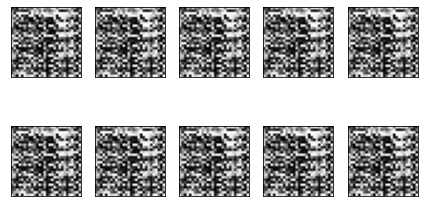

epoch = 32/100, d_loss=0.163, g_loss=0.231                                                                                                                      
epoch = 33/100, d_loss=0.163, g_loss=0.289                                                                                                                      
epoch = 34/100, d_loss=0.174, g_loss=0.448                                                                                                                      
epoch = 35/100, d_loss=0.163, g_loss=0.133                                                                                                                      
epoch = 36/100, d_loss=0.163, g_loss=0.209                                                                                                                      
epoch = 37/100, d_loss=0.163, g_loss=0.183                                                                                                                                                         

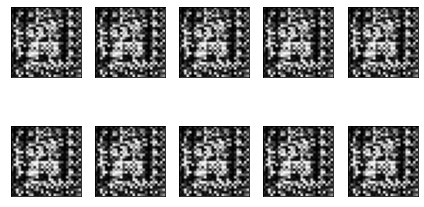

epoch = 42/100, d_loss=0.163, g_loss=0.479                                                                                                                      
epoch = 43/100, d_loss=0.163, g_loss=0.316                                                                                                                      
epoch = 44/100, d_loss=0.163, g_loss=1.285                                                                                                                      
epoch = 45/100, d_loss=0.163, g_loss=0.993                                                                                                                                                                                                                          
epoch = 46/100, d_loss=0.163, g_loss=1.613                                                                                                                      
epoch = 47/100, d_loss=0.163, g_loss=1.315                                                     

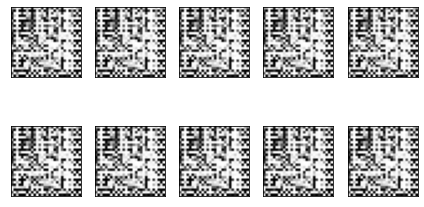

epoch = 52/100, d_loss=0.170, g_loss=2.266                                                                                                                      
epoch = 53/100, d_loss=0.163, g_loss=1.932                                                                                                                      
epoch = 54/100, d_loss=0.163, g_loss=2.404                                                                                                                      
epoch = 55/100, d_loss=0.163, g_loss=2.373                                                                                                                      
epoch = 56/100, d_loss=0.163, g_loss=2.764                                                                                                                      
epoch = 57/100, d_loss=0.163, g_loss=2.892                                                                                                                      
epoch = 58/100, d_loss=0.163, g_lo

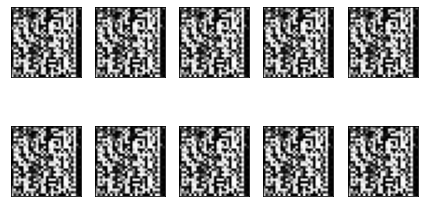

epoch = 62/100, d_loss=0.163, g_loss=2.556                                                                                                                      
epoch = 63/100, d_loss=0.163, g_loss=2.437                                                                                                                                                                                                                          
epoch = 64/100, d_loss=0.163, g_loss=1.333                                                                                                                      
epoch = 65/100, d_loss=0.163, g_loss=0.727                                                                                                                      
epoch = 66/100, d_loss=0.163, g_loss=1.010                                                                                                                                                                                                                      

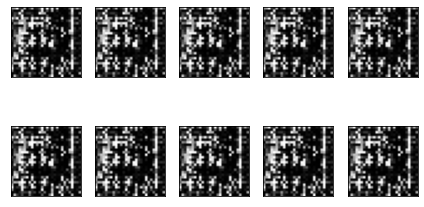

epoch = 72/100, d_loss=0.163, g_loss=0.506                                                                                                                      
epoch = 73/100, d_loss=0.163, g_loss=0.316                                                                                                                                                                                                                           
epoch = 74/100, d_loss=0.163, g_loss=0.381                                                                                                                                                                                                                          
epoch = 75/100, d_loss=0.163, g_loss=0.475                                                                                                                      
epoch = 76/100, d_loss=0.163, g_loss=0.913                                                                                                                 

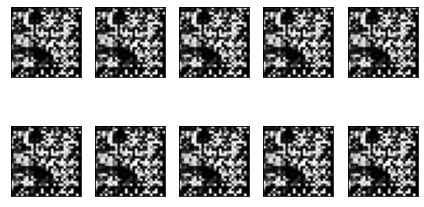

epoch = 82/100, d_loss=0.163, g_loss=0.953                                                                                                                                                                                                                                                                                                                               
epoch = 83/100, d_loss=0.163, g_loss=0.710                                                                                                                      
epoch = 84/100, d_loss=0.163, g_loss=1.178                                                                                                                                                                                                                                                                                                                             
epoch = 85/100, d_loss=0.163, g_loss=1.168                                                                           

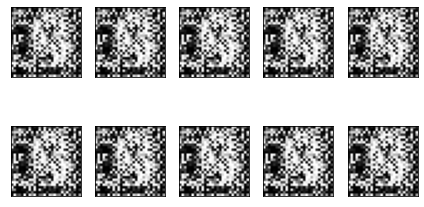

epoch = 92/100, d_loss=0.163, g_loss=1.062                                                                                                                      
epoch = 93/100, d_loss=0.163, g_loss=1.085                                                                                                                      
epoch = 94/100, d_loss=0.163, g_loss=1.626                                                                                                                                                                                                                          
epoch = 95/100, d_loss=0.163, g_loss=1.706                                                                                                                                                                                                                          
epoch = 96/100, d_loss=0.163, g_loss=0.961                                                                                                                  

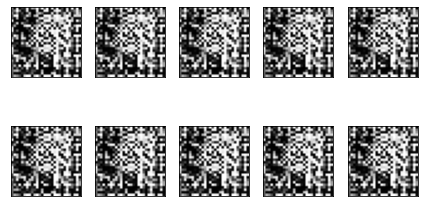

In [31]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        d_g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

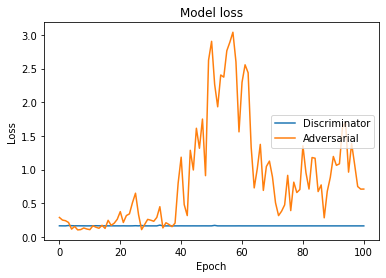

In [32]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

In [33]:
d_g.save("dcgan_trained.model")

INFO:tensorflow:Assets written to: dcgan_trained.model\assets


In [34]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(d_g, "tfjs_dcgan_model")

In [35]:
generator.save("dcgan_generator_trained.model")
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(generator, "tfjs_dcgan_generator_model")

INFO:tensorflow:Assets written to: dcgan_generator_trained.model\assets


## References

* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)
* [GAN — DCGAN (Deep convolutional generative adversarial networks)](https://medium.com/@jonathan_hui/gan-dcgan-deep-convolutional-generative-adversarial-networks-df855c438f)